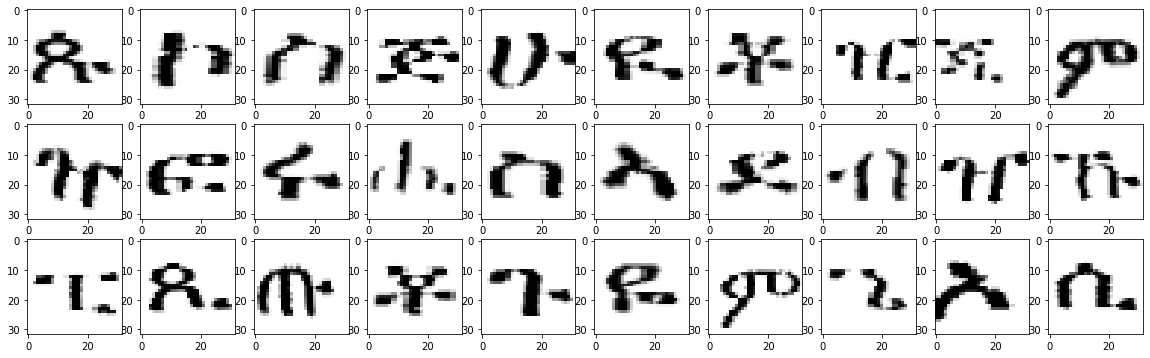

In [1]:
import numpy as np
import visualkeras as vk 

from keras import Model
from keras.models import load_model
from keras.optimizers import gradient_descent_v2
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Conv2DTranspose, concatenate
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.utils import shuffle

# The images are Grey-level with a size of 32 by 32 pixels. 231 basic Amharic characters.

train_data = np.load("../datasets/Amharic character Image dataset/Type-II/train_char/X_train_char.npy")
test_data = np.load("../datasets/Amharic character Image dataset/Type-II/test_char/X_test_char.npy")
train_labels = np.load("../datasets/Amharic character Image dataset/Type-II/train_char/y_train_char.npy")
test_labels = np.load("../datasets/Amharic character Image dataset/Type-II/test_char/y_test_char.npy")

# print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape, sep='\n')

# Normalization and Catagorization of the labels

train_data = train_data / 255.0
test_data = test_data / 255.0

train_labels = np_utils.to_categorical(train_labels)
test_labels = np_utils.to_categorical(test_labels)

# print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape, sep='\n')

shuffled_data = shuffle(np.concatenate((train_data, test_data)))
rows, cols = 10, 3

plt.figure(figsize=(20,6))

for i in range(rows * cols):
    plt.subplot(cols, rows, i + 1)
    plt.imshow(np.reshape(shuffled_data[i], (32,32)), interpolation='nearest', cmap='gray') # cmap='gray' Greys

In [2]:
# UNET with 2 downsampling and upsampling layer

# feature extraction

inputs = Input(train_data.shape[1:])

conv1 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = Dropout(rate=0.1) (conv1)
conv1 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv1)
maxpool1 = MaxPool2D(pool_size=2) (conv1)

conv2 = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (maxpool1)
conv2 = Dropout(rate=0.1) (conv2)
conv2 = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv2)
maxpool2 = MaxPool2D(pool_size=2) (conv2)

conv3 = Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (maxpool2)
conv3 = Dropout(rate=0.1) (conv3)
conv3 = Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv3)


upconv4 = Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding='same') (conv3)
upconv4 = concatenate(inputs=[upconv4, conv2])
conv4 = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (upconv4)
conv4 = Dropout(rate=0.1) (conv4)
conv4 = Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv4)

upconv5 = Conv2DTranspose(filters=16, kernel_size=2, strides=2, padding='same') (conv4)
upconv5 = concatenate(inputs=[upconv5, conv1])
conv5 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (upconv5)
conv5 = Dropout(rate=0.1) (conv5)
conv5 = Conv2D(filters=16, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same') (conv5)


maxpool3 = MaxPool2D(pool_size=2) (conv5)

# classification

outputs = Flatten() (maxpool3)
outputs = Dense(128, activation='relu') (outputs)
outputs = Dense(256, activation='relu') (outputs)
outputs = Dense(231, activation='softmax') (outputs)


model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy') #loss="categorical_crossentropy" loss='binary_crossentropy'


opt = gradient_descent_v2.SGD(momentum=0.9,)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) # sparse_categorical_crossentropy

In [ ]:
model.summary()

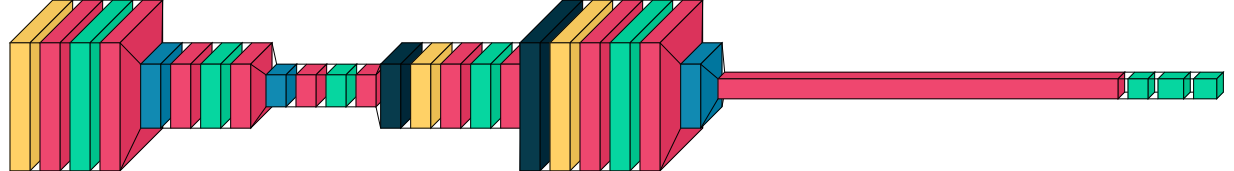

In [13]:
vk.layered_view(model)

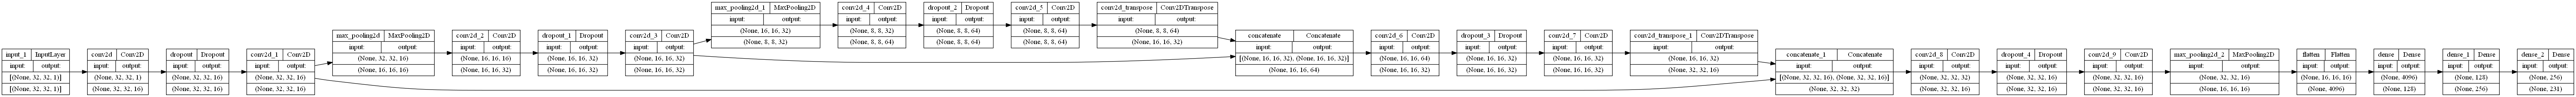

In [7]:
from keras.utils.vis_utils import plot_model

plot_model(
    model,
    to_file="../datasets/Amharic character Image dataset/models/unet2-arct/model.png",
    show_shapes=True,
    rankdir="LR" #TB for vertical
)

In [14]:
callbacks = [
    ModelCheckpoint(
        filepath="../datasets/Amharic character Image dataset/models/unet2-arct/best_loss_model.h5",
        monitor="loss",
        save_best_only=True,
        save_weights_only=False,
        mode="min"
    ),

    ModelCheckpoint(
        filepath="../datasets/Amharic character Image dataset/models/unet2-arct/best_val_loss_model.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False, 
        mode="min"
    ),

    EarlyStopping(
        monitor = 'val_loss',
        patience = 10
    ),

    TensorBoard(
        log_dir="../datasets/Amharic character Image dataset/models/unet2-arct"
    )

]

In [ ]:
history = model.fit(
    train_data,
    train_labels,
    validation_data=(test_data, test_labels), 
    epochs=100, 
    batch_size=150, 
    callbacks=[callbacks]
)

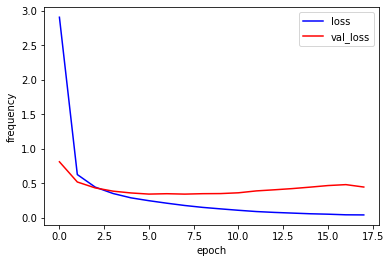

In [16]:
plt.plot(history.history["loss"], 'b', label="loss")
plt.plot(history.history["val_loss"], 'r', label="val_loss")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

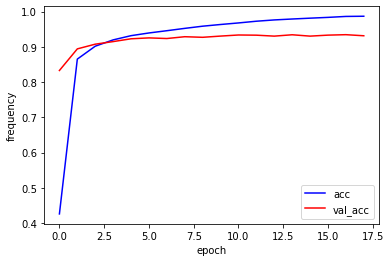

In [17]:
plt.plot(history.history["accuracy"], 'b', label="acc")
plt.plot(history.history["val_accuracy"], 'r', label="val_acc")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [2]:
model = load_model("../datasets/Amharic character Image dataset/models/unet2-arct/best_val_loss_model.h5")

loss, acc = model.evaluate(test_data, test_labels)

print('accuracy: {:5.4f}%'.format(100 * acc))
print('val_loss: {:5.4f}%'.format(100 * loss))

244/244 [==============================] - 4s 5ms/step - loss: 0.3433 - accuracy: 0.9286
accuracy: 92.8590%
val_loss: 34.3306%


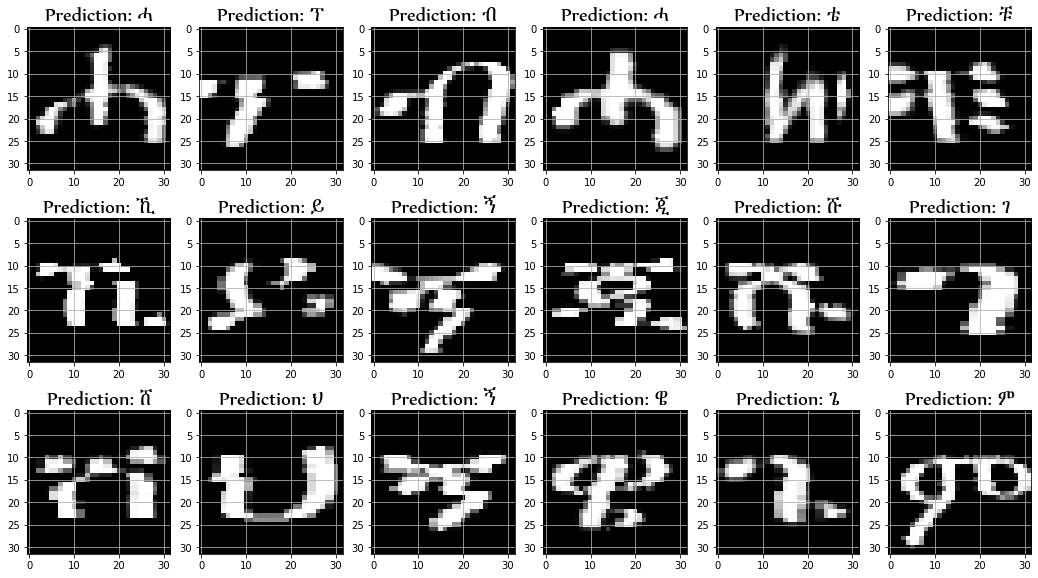

In [3]:
predictions = model.predict(test_data)

AMHARIC_ALPHABET = ['ሀ',
 'ሁ',
 'ሂ',
 'ሃ',
 'ሄ',
 'ህ',
 'ሆ',
 'ለ',
 'ሉ',
 'ሊ',
 'ላ',
 'ሌ',
 'ል',
 'ሎ',
 'ሐ',
 'ሑ',
 'ሒ',
 'ሓ',
 'ሔ',
 'ሕ',
 'ሖ',
 'መ',
 'ሙ',
 'ሚ',
 'ማ',
 'ሜ',
 'ም',
 'ሞ',
 'ሠ',
 'ሡ',
 'ሢ',
 'ሣ',
 'ሤ',
 'ሥ',
 'ሦ',
 'ረ',
 'ሩ',
 'ሪ',
 'ራ',
 'ሬ',
 'ር',
 'ሮ',
 'ሰ',
 'ሱ',
 'ሲ',
 'ሳ',
 'ሴ',
 'ስ',
 'ሶ',
 'ሸ',
 'ሹ',
 'ሺ',
 'ሻ',
 'ሼ',
 'ሽ',
 'ሾ',
 'ቀ',
 'ቁ',
 'ቂ',
 'ቃ',
 'ቄ',
 'ቅ',
 'ቆ',
 'በ',
 'ቡ',
 'ቢ',
 'ባ',
 'ቤ',
 'ብ',
 'ቦ',
 'ተ',
 'ቱ',
 'ቲ',
 'ታ',
 'ቴ',
 'ት',
 'ቶ',
 'ቸ',
 'ቹ',
 'ቺ',
 'ቻ',
 'ቼ',
 'ች',
 'ቾ',
 'ኀ',
 'ኁ',
 'ኂ',
 'ኃ',
 'ኄ',
 'ኅ',
 'ኆ',
 'ነ',
 'ኑ',
 'ኒ',
 'ና',
 'ኔ',
 'ን',
 'ኖ',
 'ኘ',
 'ኙ',
 'ኚ',
 'ኛ',
 'ኜ',
 'ኝ',
 'ኞ',
 'አ',
 'ኡ',
 'ኢ',
 'ኣ',
 'ኤ',
 'እ',
 'ኦ',
 'ከ',
 'ኩ',
 'ኪ',
 'ካ',
 'ኬ',
 'ክ',
 'ኮ',
 'ኸ',
 'ኹ',
 'ኺ',
 'ኻ',
 'ኼ',
 'ኽ',
 'ኾ',
 'ወ',
 'ዉ',
 'ዊ',
 'ዋ',
 'ዌ',
 'ው',
 'ዎ',
 'ዐ',
 'ዑ',
 'ዒ',
 'ዓ',
 'ዔ',
 'ዕ',
 'ዖ',
 'ዘ',
 'ዙ',
 'ዚ',
 'ዛ',
 'ዜ',
 'ዝ',
 'ዞ',
 'ዠ',
 'ዡ',
 'ዢ',
 'ዣ',
 'ዤ',
 'ዥ',
 'ዦ',
 'የ',
 'ዩ',
 'ዪ',
 'ያ',
 'ዬ',
 'ይ',
 'ዮ',
 'ደ',
 'ዱ',
 'ዲ',
 'ዳ',
 'ዴ',
 'ድ',
 'ዶ',
 'ጀ',
 'ጁ',
 'ጂ',
 'ጃ',
 'ጄ',
 'ጅ',
 'ጆ',
 'ገ',
 'ጉ',
 'ጊ',
 'ጋ',
 'ጌ',
 'ግ',
 'ጎ',
 'ጠ',
 'ጡ',
 'ጢ',
 'ጣ',
 'ጤ',
 'ጥ',
 'ጦ',
 'ጨ',
 'ጩ',
 'ጪ',
 'ጫ',
 'ጬ',
 'ጭ',
 'ጮ',
 'ጰ',
 'ጱ',
 'ጲ',
 'ጳ',
 'ጴ',
 'ጵ',
 'ጶ',
 'ጸ',
 'ጹ',
 'ጺ',
 'ጻ',
 'ጼ',
 'ጽ',
 'ጾ',
 'ፀ',
 'ፁ',
 'ፂ',
 'ፃ',
 'ፄ',
 'ፅ',
 'ፆ',
 'ፈ',
 'ፉ',
 'ፊ',
 'ፋ',
 'ፌ',
 'ፍ',
 'ፎ',
 'ፐ',
 'ፑ',
 'ፒ',
 'ፓ',
 'ፔ',
 'ፕ',
 'ፖ']

fig, axes = plt.subplots(3,6, figsize=(18,10))
axes = axes.flatten()


prop = FontProperties()
prop.set_file("../datasets/Amharic character Image dataset/nyala.ttf")

for i,ax in enumerate(axes):
    img = np.reshape(test_data[i], (32,32))
    ax.imshow(img, cmap='Greys')

    label = AMHARIC_ALPHABET[(np.argmax(predictions[i]))] # remember it it the indices therefore starts from 0
    ax.set_title("Prediction: " + label, fontproperties=prop, fontsize=22)
    ax.axis('on')
    ax.grid()